In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
import pandas as pd

# 웹 페이지에서 CSV 데이터를 읽을 때 첫 번째 열을 인덱스로 설정
url = "https://zenodo.org/records/4561253/files/WELFake_Dataset.csv"
data = pd.read_csv(url, sep=",", index_col=0, quoting=1)



In [3]:
X = pd.DataFrame(data=data['title'])
Y = pd.DataFrame(data=data['label'])

In [4]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [5]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True)

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [7]:
from transformers import RobertaTokenizer
from tqdm import tqdm

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# RoBERTa 모델을 위한 전처리 함수 (배치 처리)
def preprocess_for_roberta(texts, tokenizer, batch_size=32, max_length=128):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i + batch_size]
        # 수정된 부분: batch_encode_plus 사용
        batch_inputs = tokenizer.batch_encode_plus(
            batch_texts,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(batch_inputs['input_ids'])
        attention_masks.append(batch_inputs['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [8]:
train_input_ids, train_attention_masks = preprocess_for_roberta(train_texts, tokenizer)
val_input_ids, val_attention_masks = preprocess_for_roberta(val_texts, tokenizer)

Processing: 100%|██████████| 451/451 [00:02<00:00, 198.06it/s]


In [9]:
# RoBERTa 모델 로드
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [10]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [10]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks)).batch(batch_size)

    features = []
    for batch_input_ids, batch_attention_masks in tqdm(dataset, desc="Generating Features"):
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state[:, 0, :])  # 첫 번째 토큰(CLS)의 벡터 사용

    return tf.concat(features, axis=0)

In [11]:
train_features = create_transformer_input(train_input_ids, train_attention_masks)
val_features = create_transformer_input(val_input_ids, val_attention_masks)

Generating Features: 100%|██████████| 451/451 [01:24<00:00,  5.36it/s]


In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tqdm import tqdm

# Denoising Autoencoder: Input에서 일부 토큰을 무작위로 마스킹
def add_noise_and_mask(inputs, mask_token_id, mask_prob=0.15):
    mask = np.random.rand(*inputs.shape) < mask_prob
    masked_inputs = np.where(mask, mask_token_id, inputs)
    return masked_inputs, mask


# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=head_size, kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Transformer Decoder
def transformer_decoder(inputs, encoder_outputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, encoder_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + res
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=head_size, kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# FND-NS 모델 빌드 함수
def build_fnd_ns_model(input_shape, head_size, num_heads, ff_dim, num_encoder_layers, num_decoder_layers, num_classes, dropout=0):
    encoder_inputs = layers.Input(shape=input_shape)
    decoder_inputs = layers.Input(shape=input_shape)

    # Segment Embeddings
    segment_inputs = layers.Input(shape=(input_shape[0],), dtype=tf.int32)
    segment_embeddings = layers.Embedding(2, input_shape[1])(segment_inputs)
    encoder_inputs_with_segment = layers.Add()([encoder_inputs, segment_embeddings])

    # Encoder
    x = encoder_inputs_with_segment
    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    encoder_outputs = x

    # Decoder
    y = decoder_inputs
    for _ in range(num_decoder_layers):
        y = transformer_decoder(y, encoder_outputs, head_size, num_heads, ff_dim, dropout)

    # Output Layer (Softmax for binary classification)
    outputs = layers.Dense(num_classes, activation='softmax')(y[:, 0, :])  # 소프트맥스를 사용하여 이진 분류

    model = models.Model(inputs=[encoder_inputs, decoder_inputs, segment_inputs], outputs=outputs)
    return model

In [25]:
# 모델 설정
input_shape = (1, 768)  # 시퀀스 길이를 1로 설정
head_size = 768  # head_size를 input_shape의 마지막 차원과 동일하게 설정
num_heads = 8
ff_dim = 3072
num_encoder_layers = 6
num_decoder_layers = 6
num_classes = 2  # 이진 분류
dropout = 0.1

In [26]:
# 모델 빌드 및 컴파일
model = build_fnd_ns_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    num_classes=num_classes,
    dropout=dropout
)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy로 변경
              metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 1, 768)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 768)         │          1,536 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_62 (Add)              │ (None, 1, 768)         │              0 │ input_layer_6[0][0],   │
│                           │                        │                │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_36   │ (None, 1, 768)         │     18,893,568 │ add_62[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_62[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_97 (Dropout)      │ (None, 1, 768)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_60    │ (None, 1, 768)         │          1,536 │ dropout_97[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_63 (Add)              │ (None, 1, 768)         │              0 │ layer_normalization_6… │
│                           │                        │                │ add_62[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 1, 3072)        │      2,362,368 │ add_63[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_98 (Dropout)      │ (None, 1, 3072)        │              0 │ conv1d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 1, 768)         │      2,360,064 │ dropout_98[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_61    │ (None, 1, 768)         │          1,536 │ conv1d_49[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_64 (Add)              │ (None, 1, 768)         │              0 │ layer_normalization_6… │
│                           │                        │                │ add_63[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_37   │ (None, 1, 768)         │     18,893,568 │ add_64[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_64[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_100 (Dropout)     │ (None, 1, 768)         │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 396,802,562 (1.48 GB)

 Trainable params: 396,802,562 (1.48 GB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 마스킹된 입력 생성
mask_token_id = tokenizer.mask_token_id
train_masked_inputs, train_masks = add_noise_and_mask(train_input_ids.numpy(), mask_token_id)
val_masked_inputs, val_masks = add_noise_and_mask(val_input_ids.numpy(), mask_token_id)

In [48]:
# 데이터 준비: train_masked_inputs와 val_masked_inputs을 올바른 모양으로 맞추기
train_masked_inputs = tf.expand_dims(train_features, 1)
val_masked_inputs = tf.expand_dims(val_features, 1)

# 입력 데이터 형태를 (batch_size, 1, 768)로 맞추기
train_masked_inputs = tf.reshape(train_masked_inputs, (-1, 1, 768))
val_masked_inputs = tf.reshape(val_masked_inputs, (-1, 1, 768))

# 세그먼트 입력 (0으로 채움)
train_segments = tf.zeros((train_features.shape[0], 1), dtype=tf.int32)
val_segments = tf.zeros((val_features.shape[0], 1), dtype=tf.int32)

In [27]:
print(train_features.shape)
print(val_features.shape)

(57707, 768)
(14427, 768)


In [108]:
# 모델 학습
history = model.fit(
    [train_masked_inputs, train_masked_inputs, train_segments],
    tf.convert_to_tensor(train_labels),
    validation_data=([val_masked_inputs, val_masked_inputs, val_segments], tf.convert_to_tensor(val_labels)),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 324s 127ms/step - accuracy: 0.8098 - loss: 1.3215 - val_accuracy: 0.9250 - val_loss: 0.2158
Epoch 2/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 167s 92ms/step - accuracy: 0.9156 - loss: 0.2348 - val_accuracy: 0.9265 - val_loss: 0.1953
Epoch 3/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.9212 - loss: 0.2163 - val_accuracy: 0.9319 - val_loss: 0.1792
Epoch 4/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.9260 - loss: 0.2015 - val_accuracy: 0.9375 - val_loss: 0.1562
Epoch 5/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.9273 - loss: 0.1921 - val_accuracy: 0.9344 - val_loss: 0.1700
Epoch 6/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 167s 92ms/step - accuracy: 0.9314 - loss: 0.1794 - val_accuracy: 0.9357 - val_loss: 0.1634
Epoch 7/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 167s 92ms/step - accuracy: 0.9339 - loss: 0.1723 - val_accuracy: 0.9382 - val_loss: 0.1578
Epoch 8/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy:

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [121]:
# 모델 예측
val_predictions = model.predict([val_masked_inputs, val_masked_inputs, val_segments])
val_predictions = np.argmax(val_predictions, axis=1)

# 혼동 행렬 계산
cm = confusion_matrix(val_labels, val_predictions)


ValueError: Input 0 of layer "functional_14" is incompatible with the layer: expected shape=(None, 128, 768), found shape=(32, 1, 768)

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Denoising Autoencoder: Input에서 일부 토큰을 무작위로 마스킹
def add_noise_and_mask(inputs, mask_token_id, mask_prob=0.15):
    mask = np.random.rand(*inputs.shape) < mask_prob
    masked_inputs = np.where(mask, mask_token_id, inputs)
    return masked_inputs, mask

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=head_size, kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Transformer Decoder with masked self-attention
def transformer_decoder(inputs, encoder_outputs, head_size, num_heads, ff_dim, dropout=0):
    # Masked Self-Attention
    causal_mask = tf.linalg.band_part(tf.ones((inputs.shape[1], inputs.shape[1])), -1, 0)  # Lower triangular matrix
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(
        inputs, inputs, attention_mask=causal_mask
    )
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Encoder-Decoder Cross-Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, encoder_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + res

    # Feed Forward
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=head_size, kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# FND-NS 모델 빌드 함수
def build_fnd_ns_model(input_shape, head_size, num_heads, ff_dim, num_encoder_layers, num_decoder_layers, dropout=0):
    encoder_inputs = layers.Input(shape=input_shape)
    decoder_inputs = layers.Input(shape=input_shape)

    # Segment Embeddings
    segment_inputs = layers.Input(shape=(input_shape[0],), dtype=tf.int32)
    segment_embeddings = layers.Embedding(2, input_shape[1])(segment_inputs)
    encoder_inputs_with_segment = layers.Add()([encoder_inputs, segment_embeddings])

    # Encoder
    x = encoder_inputs_with_segment
    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    encoder_outputs = x

    # Decoder
    y = decoder_inputs
    for _ in range(num_decoder_layers):
        y = transformer_decoder(y, encoder_outputs, head_size, num_heads, ff_dim, dropout)

    # Output Layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(y[:, 0, :])  # Sigmoid activation for binary classification

    model = models.Model(inputs=[encoder_inputs, decoder_inputs, segment_inputs], outputs=outputs)
    return model

In [40]:
# 모델 설정
input_shape = (1, 768)  # 시퀀스 길이 줄이기
head_size = 768
num_heads = 8
ff_dim = 3072
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.1

In [42]:
# 모델 빌드 및 컴파일
model = build_fnd_ns_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout=dropout
)


In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',  # Binary Cross Entropy for binary classification
              metrics=['accuracy'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 1, 768)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 768)         │          1,536 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_124 (Add)             │ (None, 1, 768)         │              0 │ input_layer_12[0][0],  │
│                           │                        │                │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_72   │ (None, 1, 768)         │     18,893,568 │ add_124[0][0],         │
│ (MultiHeadAttention)      │                        │                │ add_124[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_193 (Dropout)     │ (None, 1, 768)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_120   │ (None, 1, 768)         │          1,536 │ dropout_193[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_125 (Add)             │ (None, 1, 768)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_124[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_96 (Conv1D)        │ (None, 1, 3072)        │      2,362,368 │ add_125[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_194 (Dropout)     │ (None, 1, 3072)        │              0 │ conv1d_96[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_97 (Conv1D)        │ (None, 1, 768)         │      2,360,064 │ dropout_194[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_121   │ (None, 1, 768)         │          1,536 │ conv1d_97[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_126 (Add)             │ (None, 1, 768)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_125[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_73   │ (None, 1, 768)         │     18,893,568 │ add_126[0][0],         │
│ (MultiHeadAttention)      │                        │                │ add_126[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_196 (Dropout)     │ (None, 1, 768)         │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 396,801,793 (1.48 GB)

 Trainable params: 396,801,793 (1.48 GB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# 마스킹된 입력 생성
mask_token_id = 1  # Assuming <mask> token id is 1
train_masked_inputs, train_masks = add_noise_and_mask(train_input_ids.numpy(), mask_token_id)
val_masked_inputs, val_masks = add_noise_and_mask(val_input_ids.numpy(), mask_token_id)

In [32]:
# 데이터 준비: train_masked_inputs와 val_masked_inputs을 올바른 모양으로 맞추기
train_masked_inputs = tf.expand_dims(train_features, 1)
val_masked_inputs = tf.expand_dims(val_features, 1)

# 입력 데이터 형태를 (batch_size, 1, 768)로 맞추기
train_masked_inputs = tf.reshape(train_masked_inputs, (-1, 1, 768))
val_masked_inputs = tf.reshape(val_masked_inputs, (-1, 1, 768))

# 세그먼트 입력 (0으로 채움)
train_segments = tf.zeros((train_features.shape[0], 1), dtype=tf.int32)
val_segments = tf.zeros((val_features.shape[0], 1), dtype=tf.int32)

# train_features와 val_features의 차원을 (batch_size, 1, 768)로 변경
train_features = tf.expand_dims(train_features, 1)
val_features = tf.expand_dims(val_features, 1)

In [33]:
# 데이터 형태 확인
print("train_masked_inputs shape:", train_masked_inputs.shape)
print("train_features shape:", train_features.shape)
print("val_masked_inputs shape:", val_masked_inputs.shape)
print("val_features shape:", val_features.shape)

train_masked_inputs shape: (57707, 1, 768)
train_features shape: (57707, 1, 768)
val_masked_inputs shape: (14427, 1, 768)
val_features shape: (14427, 1, 768)


In [44]:
# 모델 학습
history = model.fit(
    [train_masked_inputs, train_features, train_segments],
    tf.convert_to_tensor(train_labels),
    validation_data=([val_masked_inputs, val_features, val_segments], tf.convert_to_tensor(val_labels)),
    epochs=10,
    batch_size=32
)


Epoch 1/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 308s 121ms/step - accuracy: 0.8104 - loss: 1.1074 - val_accuracy: 0.8273 - val_loss: 0.5635
Epoch 2/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy: 0.9158 - loss: 0.2343 - val_accuracy: 0.9256 - val_loss: 0.1978
Epoch 3/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 162s 90ms/step - accuracy: 0.9250 - loss: 0.2002 - val_accuracy: 0.9338 - val_loss: 0.1751
Epoch 4/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy: 0.9289 - loss: 0.1882 - val_accuracy: 0.9410 - val_loss: 0.1530
Epoch 5/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 162s 90ms/step - accuracy: 0.9288 - loss: 0.1873 - val_accuracy: 0.9408 - val_loss: 0.1504
Epoch 6/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy: 0.9354 - loss: 0.1684 - val_accuracy: 0.9408 - val_loss: 0.1546
Epoch 7/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy: 0.9348 - loss: 0.1681 - val_accuracy: 0.9156 - val_loss: 0.2564
Epoch 8/10
1804/1804 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy:

In [45]:
# 모델 평가
val_predictions = model.predict([val_masked_inputs, val_masked_inputs, val_segments])
val_predictions_binary = (val_predictions > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


451/451 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step


In [48]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 혼동 행렬 및 성능 지표 출력
conf_matrix = confusion_matrix(val_labels, val_predictions_binary)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[6682  253]
 [ 603 6889]]


In [49]:
# 정밀도, 재현율, F1 스코어 등 출력
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary))




Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6935
           1       0.96      0.92      0.94      7492

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



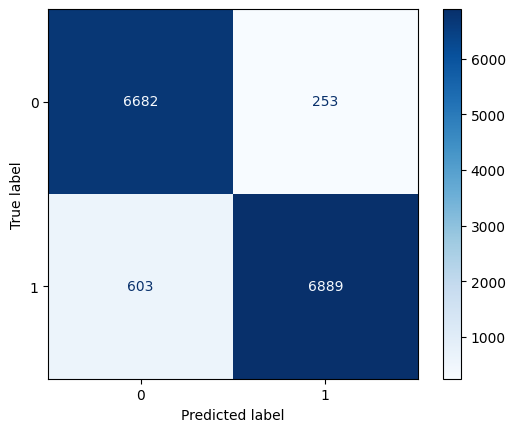

In [51]:
import matplotlib.pyplot as plt

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()